This is an expiremental notebook where you can specify a dataframe path and see how fastText performs on the dataset.

The dataset will remove issues made by detected bots, and additional bots can be added as well. 

Each label is predicted as a fastText binary classification task. Negative samples are evenly distributed amongst other labels.

The output will be a dataframe with the precision, accuracy, and recall for each label, computed using k-fold cross validation.

In [21]:
import pandas as pd
import numpy as np
from skift import FirstColFtClassifier
import model_validation
import itertools
import collections
import os
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [2]:
# repo data is saved as {org_name}-_-{repo_name}
# orginization data is saved as {org_name}

SAVENAME = 'thoth-station'

issues_df = pd.read_csv(os.path.join('../data', SAVENAME + '-issues.csv'))
labels_df = pd.read_csv(os.path.join('../data', SAVENAME + '-labels.csv'))

In [3]:
issues_df.sample(5)

,id,repo,title,body,created_at,created_by,num_labels
5432,thoth-station/thoth-application/291,thoth-station/thoth-application,The pod for image analysis did not run,**Describe the bug**\r\nI issued an image anal...,2020-08-21 16:00:14,bissenbay,0
2576,thoth-station/management-api/60,thoth-station/management-api,Failed to update dependencies to their latest ...,\nAutomatic dependency update failed for the c...,2019-01-30 12:52:11,sesheta,1
694,thoth-station/build-watcher/220,thoth-station/build-watcher,New minor release,"Hey, Kebechet!\r\n\r\nCreate a new minor relea...",2021-01-20 09:35:45,fridex,1
2144,thoth-station/jupyterlab-requirements/197,thoth-station/jupyterlab-requirements,use new feature of thamos to handle virtualenv...,**Is your feature request related to a problem...,2021-03-09 21:44:30,pacospace,2
1468,thoth-station/graph-sync-job/58,thoth-station/graph-sync-job,Failed to update dependencies to their latest ...,\nAutomatic dependency update failed for the c...,2018-09-09 16:15:31,sesheta,1


In [4]:
labels_df.sample(5)

,id,name
633,thoth-station/cleanup-job/197,bot
438,thoth-station/analyzer/21,bot
4203,thoth-station/storages/2250,deployment_name/ocp4-test
3301,thoth-station/qeb-hwt/113,lifecycle/rotten
4379,thoth-station/thamos/416,bot


In [5]:
# output most popular labels

cutoff = 50

cts = labels_df.name.value_counts(ascending = False)
cts[cts >= cutoff]

bot                            2186
human_intervention_required     549
kind/feature                    475
todo :spiral_notepad:           381
kind/bug                        310
good first issue                176
priority/important-soon         148
priority/backlog                129
hacktoberfest                    94
priority/critical-urgent         80
triage/needs-information         76
priority/important-longterm      76
lifecycle/rotten                 76
lifecycle/stale                  75
sig/devops                       70
help wanted                      69
deployment_name/zero-prod        61
Name: name, dtype: int64

In [6]:
# define synonyms, first in set will be used name

synsets = [['kind/bug', 'bug'],
            ['kind/feature', 'enhancement']
          ]

In [7]:
# equate synonyms

for syn in synsets:
    equate_syns = lambda x: syn[0] if x in syn[1:] else x
    labels_df['name'] = labels_df.name.apply(equate_syns)

(0, 6)

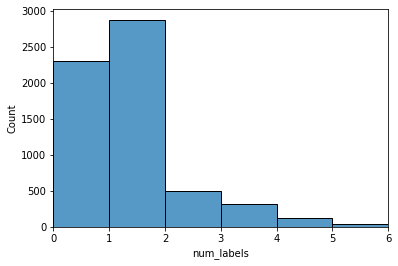

In [8]:
# output histogram of number of labels

ax = sns.histplot(issues_df.num_labels, bins = int(max(issues_df.num_labels)))
ax.set_xlim((0,6))

In [10]:
# view most common issue creators

issues_df.created_by.value_counts(ascending = False).head(10)

fridex                1565
sesheta               1299
pacospace              951
goern                  533
sentry-io[bot]         471
todo[bot]              379
harshad16              341
saisankargochhayat     170
xtuchyna               141
khebhut[bot]            98
Name: created_by, dtype: int64

In [11]:
# first find bots transparently tagged as such

is_bot = lambda x: x[-5:] == '[bot]'

all_names = issues_df.created_by.unique()

bots = all_names[[is_bot(x) for x in all_names]]

print('bots found:')
for b in bots:
    print('\t', b)

bots found:
	 todo[bot]
	 sentry-io[bot]
	 khebhut[bot]
	 dependencies[bot]
	 github-actions[bot]


In [12]:
# choose any additional bot accounts whose issues to not count

additional_bots = ['sesheta']

In [13]:
# filter out issues created by bots & their labels

bots = np.concatenate((bots, additional_bots))

issues_df = issues_df[issues_df.created_by.apply(lambda x: x not in bots)]
remaining_ids = set(issues_df.id.values)
labels_df = labels_df[labels_df.id.apply(lambda x: x in remaining_ids)]

In [14]:
# most popular labels, finalized

cutoff = 50

cts = labels_df.name.value_counts(ascending = False)

lbl_cts = cts[cts >= cutoff]

final_labels = list(lbl_cts.index)

lbl_cts

bot                            971
kind/feature                   457
human_intervention_required    423
kind/bug                       247
good first issue               156
priority/important-soon        125
priority/backlog               108
hacktoberfest                   71
priority/important-longterm     70
sig/devops                      64
triage/needs-information        63
priority/critical-urgent        62
help wanted                     57
Name: name, dtype: int64

(0, 6)

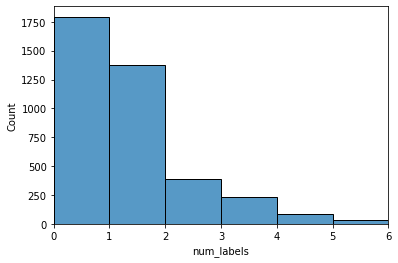

In [15]:
# output histogram of number of labels, finalized

ax = sns.histplot(issues_df.num_labels, bins = int(max(issues_df.num_labels)))
ax.set_xlim((0,6))

In [16]:
# preprocessing
issues_df = issues_df.fillna({'title': '', 'body': ''})
issues_df['body'] = issues_df['body'].apply(lambda x: x.replace('\n', ' <N> ').replace('\r', ' <R> '))
issues_df['input'] = issues_df['title'] + ' <SEP> ' + issues_df['body']

In [39]:
def get_subdataset(label):
    """
    pass in a label name and get back a dataframe of positive & negative samples for the label
    we avoid taking unlabelled data as negative samples
    negative samples are distributed evenly amongst the other labels
    """
    final_labels_ = final_labels.copy()
    final_labels_.remove(label)
    pos_samples = labels_df.query('name == "{}"'.format(label)).id
    n = len(pos_samples)
    pos_ids = set(pos_samples.values)
    remaining = labels_df[labels_df.id.apply(lambda x: x not in pos_ids)]
    n_neg = 0
    per_label = n//len(final_labels_)
    neg_ids = set()
    # evenly sample if we can
    # if not enough samples for a label, throw them all in and increase the remaining amount we need per label
    for i, lbl in enumerate(reversed(final_labels_)):
        neg_samples = remaining.query('name == "{}"'.format(lbl)).id
        if len(neg_samples) >= per_label:
            neg_samples = neg_samples.sample(per_label)
            n_neg += per_label
        else:
            n_neg += len(neg_samples)
            per_label = (n - n_neg)//(len(final_labels_) - i - 1)
        remaining = remaining[remaining.id.apply(lambda x: x not in set(neg_samples))]
        neg_ids = neg_ids.union(set(neg_samples))
    # fill in potential gap with unlabelled issues, if needed
    if len(pos_ids) > len(neg_ids):
        unlabelled = issues_df.query("num_labels == 0")
        if len(unlabelled) > len(pos_ids) - len(neg_ids):
            neg_ids = neg_ids.union(set(unlabelled.sample(len(pos_ids) - len(neg_ids)).id))
        else:
            neg_ids = neg_ids.union(set(unlabelled.ids))
            pos_samples = pos_samples.sample(len(neg_ids))
            pos_ids = set(pos_samples.id)
    final_neg_samples = issues_df[issues_df.id.apply(lambda x: x in neg_ids)].input
    final_pos_samples = issues_df[issues_df.id.apply(lambda x: x in pos_ids)].input
    X = np.concatenate((final_neg_samples.values, final_pos_samples.values)).reshape(-1, 1)
    y = np.concatenate((np.zeros(len(final_neg_samples)), np.ones(len(final_pos_samples))))
    return X, y.astype(int)

In [57]:
def predict_label(label, k = 5):
    """
    validates fastText model on the given label, using k-fold cross validation
    """
    X, y = get_subdataset(label)
    kf = KFold(n_splits=k, random_state=None, shuffle=True)
    accuracy = []
    precision = []
    recall = []
    for train_index, test_index in kf.split(X):
        model = FirstColFtClassifier()
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        accuracy.append(np.mean(preds == y_test))
        precision_ = preds[preds == 1] == y_test[preds == 1]
        if len(precision_) != 0:
            precision.append(np.mean(precision_))
        recall_ = preds[y_test == 1] == y_test[y_test == 1]
        if len(recall_) != 0:
            recall.append(np.mean(recall_))
    return pd.DataFrame([[label, len(X), np.mean(accuracy), np.mean(precision), np.mean(recall)]], columns = ['label' ,'n', 'accuracy', 'precision', 'recall'])

In [58]:
predicted_labels = []
for label in tqdm(final_labels):
    predicted_labels.append(predict_label(label))

  0%|          | 0/13 [00:00<?, ?it/s]

/opt/app-root/lib64/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/app-root/lib64/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/app-root/lib64/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/app-root/lib64/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/app-root/lib64/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/app-root/lib64/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/

NOTE: for now, labels with a low amount of samples are very biased towards predicting a 0, or a negative prediction. This could be fixed by adjusting hyperparameters (once they are explored) and/or finetuning on a pretrained model.

In [59]:
pd.concat(predicted_labels).sort_values('accuracy', ascending = False)

,label,n,accuracy,precision,recall
0,bot,1944,0.986105,0.991813,0.980467
0,kind/feature,916,0.648337,0.610143,0.581008
0,human_intervention_required,848,0.605026,0.730583,0.646451
0,kind/bug,495,0.545455,0.611053,0.826319
0,good first issue,312,0.538044,0.887500,0.097072
0,priority/critical-urgent,124,0.508333,0.529412,0.180000
0,priority/backlog,218,0.505285,NaN,0.000000
0,priority/important-longterm,141,0.503695,NaN,0.000000
0,hacktoberfest,143,0.503202,NaN,0.000000
0,priority/important-soon,250,0.500000,NaN,0.000000
